# Google Play Store Apps 


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import warnings

warnings.filterwarnings('ignore')

In [24]:
# Load Datasets
apps_df = pd.read_csv('googleplaystore.csv')
reviews_df = pd.read_csv('googleplaystore_user_reviews.csv')

In [25]:
# Clean Apps Data
apps_df.drop_duplicates(inplace=True)
apps_df.drop(index=10472, inplace=True, errors='ignore')

apps_df = apps_df[apps_df['App'].notnull() & apps_df['Category'].notnull()]
apps_df['Reviews'] = pd.to_numeric(apps_df['Reviews'], errors='coerce')
apps_df['Installs'] = apps_df['Installs'].str.replace('+', '', regex=False).str.replace(',', '', regex=False)
apps_df['Installs'] = pd.to_numeric(apps_df['Installs'], errors='coerce')
apps_df['Price'] = apps_df['Price'].str.replace('$', '', regex=False)
apps_df['Price'] = pd.to_numeric(apps_df['Price'], errors='coerce')

In [26]:
# Size Conversion
def convert_size(size):
    if 'M' in size:
        return float(size.replace('M', '')) * 1024 * 1024
    elif 'k' in size:
        return float(size.replace('k', '')) * 1024
    elif size == 'Varies with device':
        return np.nan
    return np.nan

apps_df['Size_in_bytes'] = apps_df['Size'].apply(convert_size)
apps_df['Size_MB'] = apps_df['Size_in_bytes'] / (1024 * 1024)

In [27]:
# Drop rows with critical nulls
apps_df.dropna(subset=['Reviews', 'Installs', 'Price'], inplace=True)

# Fill Ratings by Category Mean
apps_df['Rating'] = pd.to_numeric(apps_df['Rating'], errors='coerce')
apps_df['Rating'] = apps_df.groupby('Category')['Rating'].transform(lambda x: x.fillna(x.mean()))

In [28]:
# Create Install Categories
bins = [-1, 0, 10, 1000, 10000, 100000, 1000000, 10000000, 10000000000]
labels = ['no', 'Very low', 'Low', 'Moderate', 'More than moderate', 'High', 'Very High', 'Top Notch']
apps_df['Installs_category'] = pd.cut(apps_df['Installs'], bins=bins, labels=labels)

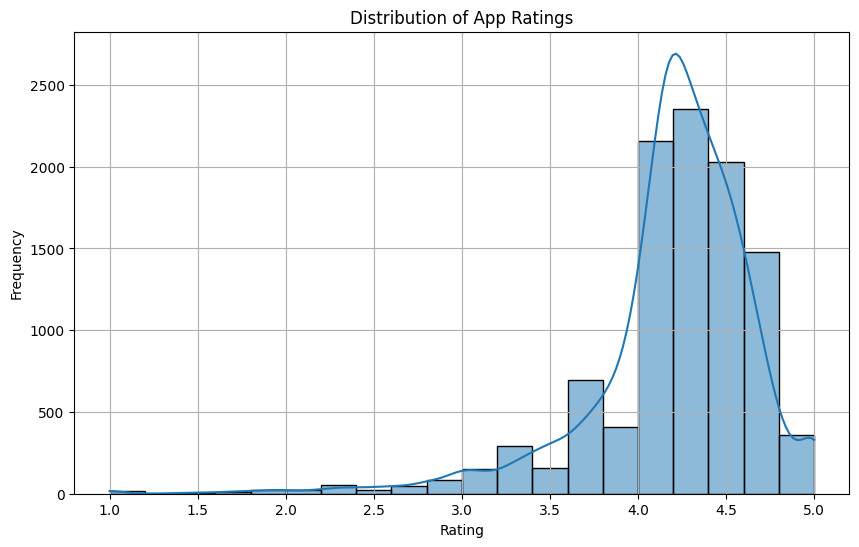

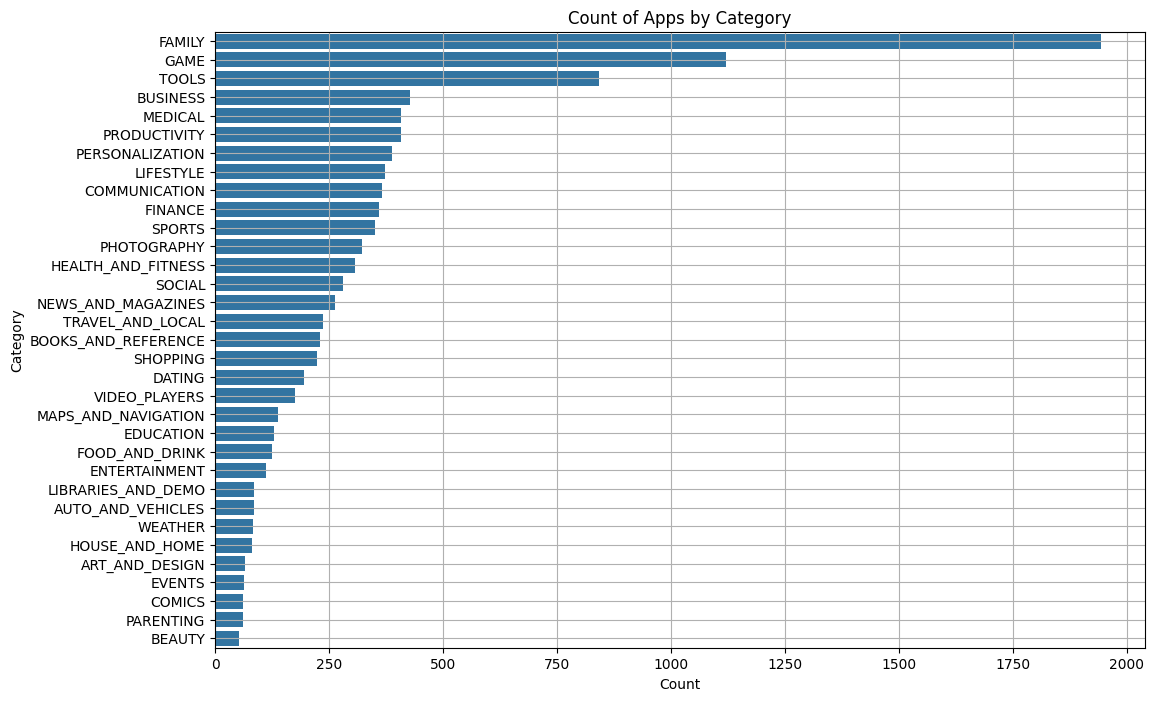

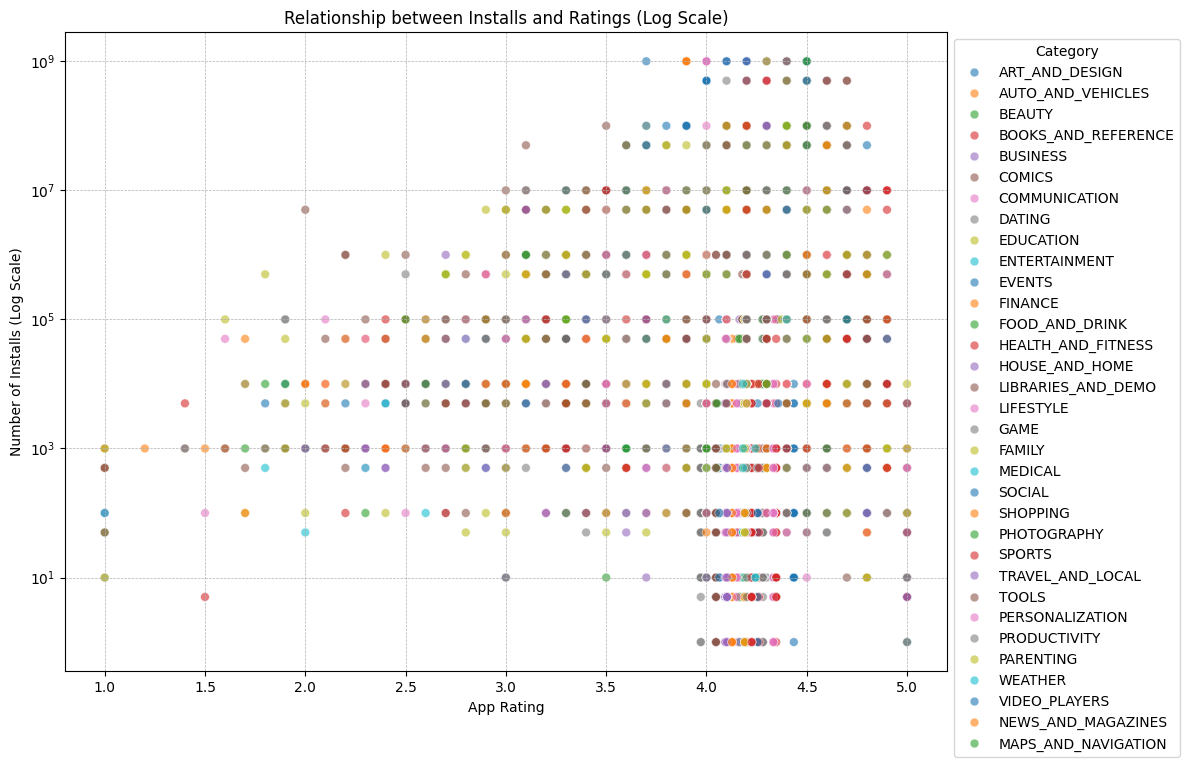

In [29]:
# Distribution of Ratings
plt.figure(figsize=(10, 6))
sns.histplot(apps_df['Rating'], bins=20, kde=True)
plt.title('Distribution of App Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Count of Apps by Category
plt.figure(figsize=(12, 8))
sns.countplot(y='Category', data=apps_df, order=apps_df['Category'].value_counts().index)
plt.title('Count of Apps by Category')
plt.xlabel('Count')
plt.ylabel('Category')
plt.grid(True)
plt.show()

# Improved Scatter Plot: Installs vs Rating
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='Rating', 
    y='Installs', 
    hue='Category', 
    data=apps_df, 
    palette='tab10', 
    alpha=0.6, 
    s=40
)
plt.yscale('log')  # Log scale for better visual separation
plt.title('Relationship between Installs and Ratings (Log Scale)')
plt.xlabel('App Rating')
plt.ylabel('Number of Installs (Log Scale)')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Category')
plt.tight_layout()
plt.show()

In [30]:
# Aggregated Insights
print("Average Rating by Category:")
print(apps_df.groupby('Category')['Rating'].mean().sort_values(ascending=False).head(10))

print("\nMost Installed Apps:")
print(apps_df[['App', 'Installs']].sort_values(by='Installs', ascending=False).head(10))

print("\nTop Genres:")
if 'Genres' in apps_df.columns:
    print(apps_df['Genres'].value_counts().head(5))
else:
    print("No 'Genres' column found in dataset.")

Average Rating by Category:
Category
EVENTS                 4.435556
EDUCATION              4.375969
ART_AND_DESIGN         4.358065
BOOKS_AND_REFERENCE    4.347458
PERSONALIZATION        4.333871
PARENTING              4.300000
GAME                   4.281285
BEAUTY                 4.278571
HEALTH_AND_FITNESS     4.261450
SOCIAL                 4.254918
Name: Rating, dtype: float64

Most Installed Apps:
                          App    Installs
865         Google Play Games  1000000000
2554                  Google+  1000000000
3687  Google Play Movies & TV  1000000000
2853            Google Photos  1000000000
3523             Google Drive  1000000000
1872           Subway Surfers  1000000000
2884            Google Photos  1000000000
3234                   Google  1000000000
2604                Instagram  1000000000
3943                 Facebook  1000000000

Top Genres:
Genres
Tools            842
Entertainment    588
Education        527
Business         427
Medical          408
Name:

In [31]:
# Clean Reviews Data
reviews_df.dropna(subset=['Translated_Review'], inplace=True)
reviews_df.drop_duplicates(inplace=True)

# Sentiment Analysis
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

reviews_df['Sentiment_Score'] = reviews_df['Translated_Review'].apply(get_sentiment)
reviews_df['Sentiment_Label'] = reviews_df['Sentiment_Score'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))

In [32]:
# Sentiment Summary
sentiment_summary = reviews_df.groupby('App')['Sentiment_Label'].value_counts().unstack().fillna(0)
sentiment_summary['Total_Reviews'] = sentiment_summary.sum(axis=1)
sentiment_summary = sentiment_summary.sort_values(by='Total_Reviews', ascending=False)

print("\nApps with Most Sentiment-Labeled Reviews:")
print(sentiment_summary.head(10))

# Merge sentiment data with app data
merged_df = apps_df.merge(sentiment_summary, left_on='App', right_index=True, how='left')

# Fill missing sentiment with 0
for col in ['Positive', 'Negative', 'Neutral']:
    if col in merged_df.columns:
        merged_df[col] = merged_df[col].fillna(0)


Apps with Most Sentiment-Labeled Reviews:
Sentiment_Label                 Negative  Neutral  Positive  Total_Reviews
App                                                                       
Facebook                            59.0     18.0      53.0          130.0
Episode - Choose Your Story         37.0     13.0      74.0          124.0
Angry Birds Classic                 59.0      1.0      47.0          107.0
Family Locator - GPS Tracker         7.0     13.0      85.0          105.0
Google Photos                       24.0      1.0      76.0          101.0
Calorie Counter - Macros            10.0      3.0      87.0          100.0
8fit Workouts & Meal Planner        11.0      7.0      82.0          100.0
Calorie Counter - MyFitnessPal      16.0     17.0      66.0           99.0
ColorNote Notepad Notes              6.0      2.0      91.0           99.0
Adobe Acrobat Reader                20.0     11.0      67.0           98.0


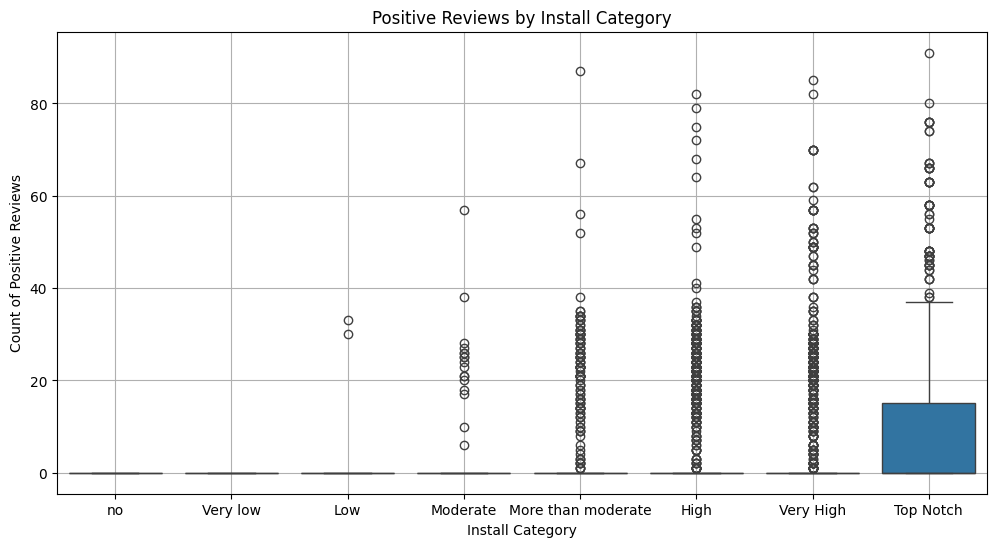

In [33]:
# Boxplot: Positive Reviews vs Install Category
plt.figure(figsize=(12, 6))
sns.boxplot(x='Installs_category', y='Positive', data=merged_df)
plt.title('Positive Reviews by Install Category')
plt.xlabel('Install Category')
plt.ylabel('Count of Positive Reviews')
plt.grid(True)
plt.show()